# Spam Emails数据集

## 1.分析目的

过滤垃圾邮件，为垃圾邮件检测创建机器学习模型，比较逻辑回归，XGBoost，svm支持向量机三种模型，找出性能更优的模型

## 数据集来源

https://www.kaggle.com/datasets/abdallahwagih/spam-emails/data

In [19]:
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings 
warnings.filterwarnings('ignore')

In [21]:
df = pd.read_csv(r'D:/github项目/数据集/spam.csv')
print ('数据集:',df.shape)

数据集: (5572, 2)


此数据集包含一组电子邮件，分为两类：“垃圾邮件”和“非垃圾邮件”（通常称为“火腿”）,包括5572条数据。两个字段

## 2.理解数据

In [22]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


### 字段解释

‌1.`Category` ‌：类别

示例：可能是 "spam"(垃圾)/"ham"(正常)、"positive"/"negative" 等文本分类标签

2‌.`Message` ：信息

示例：短信内容、邮件正文、用户评论等文本数据

In [24]:
df.isna().sum()

Category    0
Message     0
dtype: int64

In [25]:
df.duplicated().sum()

415

## 3.数据预处理

In [ ]:
# df.drop_duplicates(keep = 'last', inplace = True)
# df.duplicated().sum()

## 4.EDA数据分析

In [26]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [28]:
# 设置matplotlib的字体参数
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

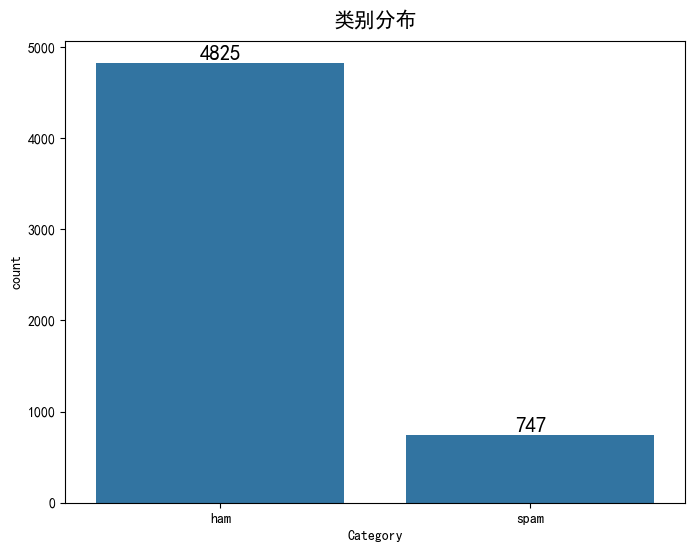

In [31]:
plt.figure(figsize = (8,6))
ax = sns.countplot(data = df, x = 'Category')
plt.title('类别分布', fontweight = 'black', pad = 10, fontsize = 15)
for container in ax.containers:
    ax.bar_label(container, fontweight = 'black', size = 15)


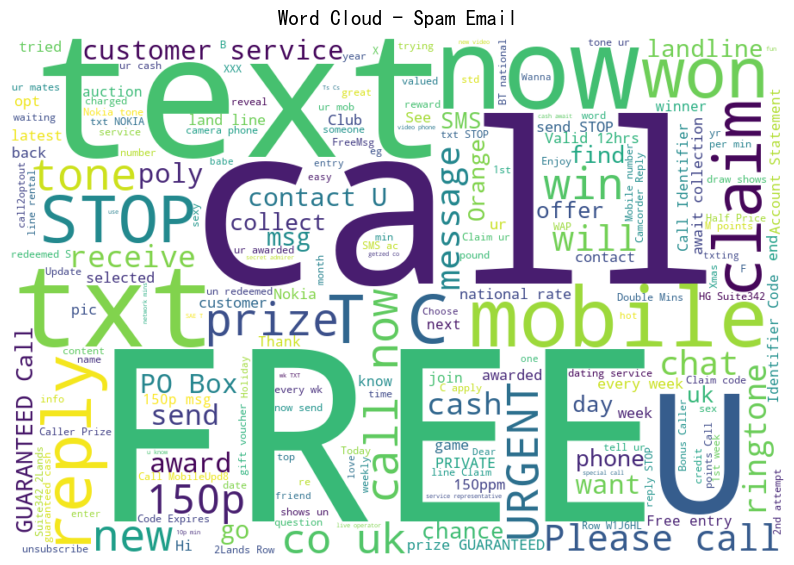

In [32]:
spam_words = ' '.join(list(df[df['Category'] == 'spam']['Message']))
wordcloud_spam = WordCloud(width = 900, height = 600, background_color = 'white').generate(spam_words)

plt.figure(figsize = (10, 8))
plt.imshow(wordcloud_spam, interpolation = 'bilinear')
plt.title('Word Cloud - Spam Email', fontweight = 'black', pad = 10, fontsize = 15)
plt.axis('off')
plt.show()

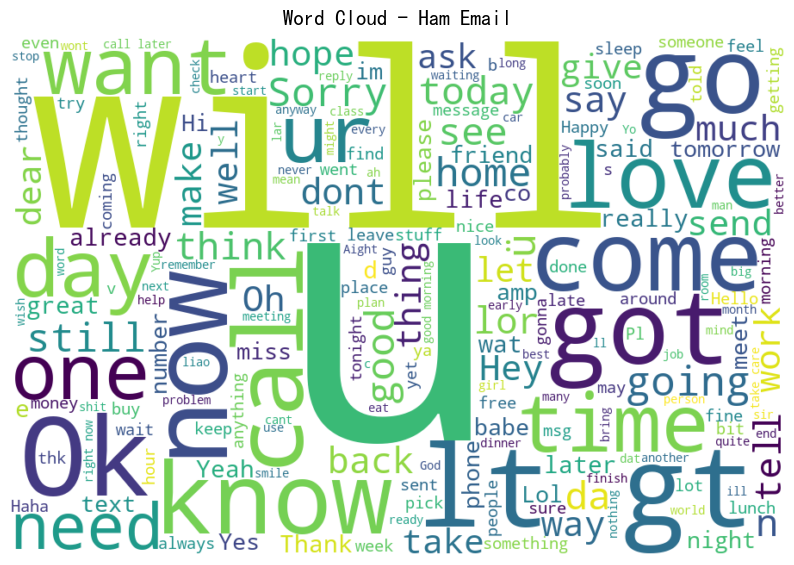

In [33]:
spam_words = ' '.join(list(df[df['Category'] == 'ham']['Message']))
wordcloud_spam = WordCloud(width = 900, height = 600, background_color = 'white').generate(spam_words)

plt.figure(figsize = (10, 8))
plt.imshow(wordcloud_spam, interpolation = 'bilinear')
plt.title('Word Cloud - Ham Email', fontweight = 'black', pad = 10, fontsize = 15)
plt.axis('off')
plt.show()

## 5.nlp过滤垃圾信息

In [34]:
# 使用 ‌spaCy‌ 库加载英文语言模型 en_core_web_md
nlp = spacy.load('en_core_web_md')

In [35]:
text = df.iloc[0,1]

In [36]:
# spaCy 自然语言处理库对文本进行处理
doc = nlp(text)
doc

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

In [37]:
for token in doc:
    print(token)

Go
until
jurong
point
,
crazy
..
Available
only
in
bugis
n
great
world
la
e
buffet
...
Cine
there
got
amore
wat
...


In [38]:
# 使用spaCy库进行文本词形还原（lemmatization）
for token in doc:
    print(token,'->', token.lemma_)

Go -> go
until -> until
jurong -> jurong
point -> point
, -> ,
crazy -> crazy
.. -> ..
Available -> available
only -> only
in -> in
bugis -> bugis
n -> n
great -> great
world -> world
la -> la
e -> e
buffet -> buffet
... -> ...
Cine -> Cine
there -> there
got -> get
amore -> amore
wat -> wat
... -> ...


In [39]:
# 识别和分类文档中的停用词、标点符号和普通词汇
for token in doc:
    if token.is_stop:
        print(f'{token} --> stop word')
    elif token.is_punct:
        print(f'{token} --> Punct')
    else:
        print(f'{token} --> Not Stop Word')

Go --> stop word
until --> stop word
jurong --> Not Stop Word
point --> Not Stop Word
, --> Punct
crazy --> Not Stop Word
.. --> Punct
Available --> Not Stop Word
only --> stop word
in --> stop word
bugis --> Not Stop Word
n --> Not Stop Word
great --> Not Stop Word
world --> Not Stop Word
la --> Not Stop Word
e --> Not Stop Word
buffet --> Not Stop Word
... --> Punct
Cine --> Not Stop Word
there --> stop word
got --> Not Stop Word
amore --> Not Stop Word
wat --> Not Stop Word
... --> Punct


In [40]:
# 清洗和标准化输入文本
def preprocessing(text):
    doc = nlp(text)
    clean_text = []

    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        clean_text.append(token.lemma_)


    return ' '.join(clean_text)

In [41]:
# 生成清洗后的列
df['clean_text'] = df['Message'].apply(preprocessing)

In [44]:
encoder = LabelEncoder()

df['label'] = encoder.fit_transform(df['Category'])

In [45]:
df.head()

,Category,Message,clean_text,label
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,0
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win FA Cup final tkts 2...,1
3,ham,U dun say so early hor... U c already then say...,U dun early hor U c,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think go usf live,0


## 6.模型

In [46]:
X = df['clean_text']
y = df['label']

In [47]:
# 将文本数据转换为TF-IDF特征矩阵
vectorizer = TfidfVectorizer()

X_vectorizer = vectorizer.fit_transform(X)

In [48]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_vectorizer, y, test_size = 0.2, random_state = 42)

### 逻辑回归/Logistic Regression

In [49]:
lr = LogisticRegression()

lr.fit(X_train, y_train)

LogisticRegression()

In [50]:
lr.score(X_train, y_train)

0.9676912721561588

In [51]:
y_pred = lr.predict(X_test)

In [52]:
print(accuracy_score(y_test,y_pred))

0.957847533632287


<Axes: >

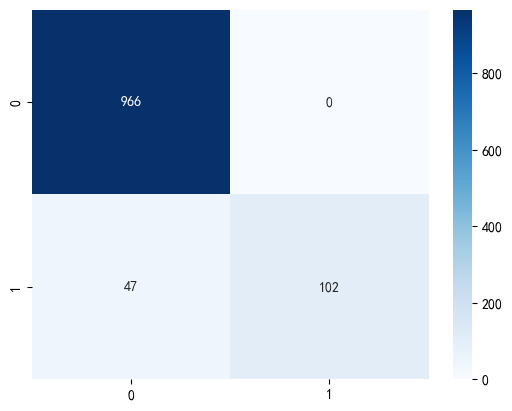

In [53]:
#混淆矩阵
cm = confusion_matrix(y_test,y_pred)

sns.heatmap(cm, annot = True, cmap = 'Blues',fmt = '1.0f')

In [54]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       966
           1       1.00      0.68      0.81       149

    accuracy                           0.96      1115
   macro avg       0.98      0.84      0.89      1115
weighted avg       0.96      0.96      0.95      1115



### XGBoost

In [55]:
xgb = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [56]:
xgb_pred = xgb.predict(X_test)

In [57]:
print(accuracy_score(y_test,xgb_pred))

0.9838565022421525


<Axes: >

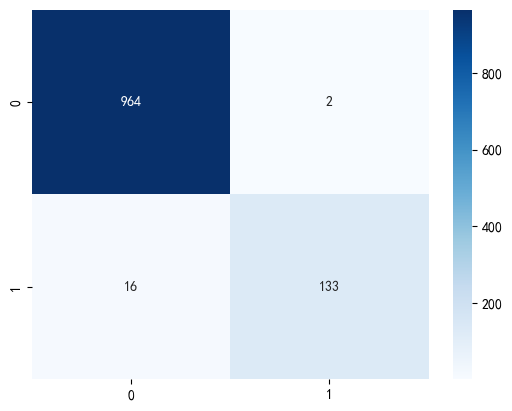

In [58]:
cm = confusion_matrix(y_test,xgb_pred)

sns.heatmap(cm, annot = True, cmap = 'Blues', fmt = '1.0f')

In [59]:
print(classification_report(y_test,xgb_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.99      0.89      0.94       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



## 支持向量机/Support Vector Machine - SVM

In [60]:
svm = SVC(kernel = 'linear', random_state = 42)
svm.fit(X_train,y_train)

SVC(kernel='linear', random_state=42)

In [61]:
svm_pred = svm.predict(X_test)

In [62]:
print(accuracy_score(y_test,svm_pred))

0.9820627802690582


<Axes: >

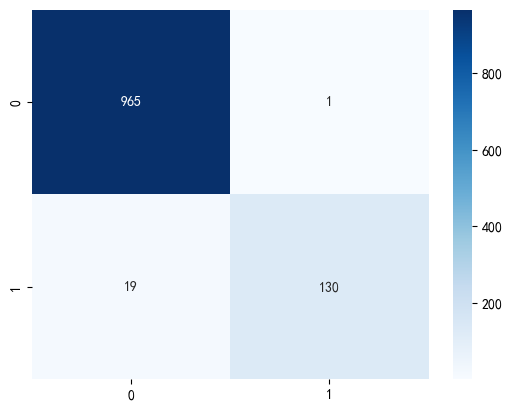

In [63]:
cm = confusion_matrix(y_test,svm_pred)

sns.heatmap(cm, annot = True, cmap = 'Blues', fmt = '1.0f')

In [64]:
print(classification_report(y_test,svm_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.99      0.87      0.93       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



## 7.结论

# 垃圾邮件检测模型比较

## XGBoost 表现最优

![模型性能对比图](images/model_comparison.png)



| 模型       | 召回率 | 精确率 | F1分数 |
|------------|--------|--------|--------|
| 逻辑回归   | 0.68   | 1.00   | 0.81   |
| XGBoost    | 0.89   | 0.99   | 0.94   |
| SVM        | 0.87   | 0.99   | 0.93   |


#### XGBoost是处理垃圾邮件的最佳模型‌，在保持高精确率(99%)的同时，实现了最高的垃圾邮件检出率(89%)。
#### 其召回率比逻辑回归高21个百分点，比SVM高2个百分点，且综合F1分数(0.94)显著优于其他模型。
#### 推荐部署XGBoost作为垃圾邮件过滤系统的基础模型。